In [1]:
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import gc
import xarray as xr
import pandas as pd
import xrft as xrft
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter as gauss
# from scipy.integrate import trapezoid as trapz
from pyspec import spectrum as spec
from matplotlib.colors import LogNorm
import warnings
import scipy.signal as sig
import scipy.stats as stats
import sys
import seaborn as sns
sys.path.append("/homes/metogra/iufarias/FeedbackSubmeso/useful/")
import romspickle


from dask.diagnostics import ProgressBar


import scipy.integrate as integ
warnings.filterwarnings("ignore")

In [2]:
def tophat_bandpass_2d(data,lowcut=40,highcut=1):
    from scipy.signal import convolve2d
    BandFilt=data.copy()
    
    for idd in range(data.shape[0]):
        lowcut= int(np.round(lowcut))

        y,x = np.ogrid[-lowcut: lowcut+1, -lowcut: lowcut+1]
        disklow = x**2+y**2 <= lowcut**2
        disklow = disklow.astype(float)
        disklow = disklow/sum(sum(disklow))
        # DiskLow = xr.DataArray(disklow, dims=['kx', 'ky']) 
        
        # convolute the fields with the kernel
        lowfiltered = convolve2d(data[idd],disklow, mode='same', boundary='fill', fillvalue=0)
        
        # LowFilt=data.copy()
        # LowFilt[idd].data=lowfiltered
        # LowPrime=data[idd]-LowFilt
        lowprime=data[idd]-lowfiltered

        highcut= int(np.round(highcut))

        y,x = np.ogrid[-highcut: highcut+1, -highcut: highcut+1]
        diskhigh = x**2+y**2 <= highcut**2
        diskhigh = diskhigh.astype(float)
        diskhigh = diskhigh/sum(sum(diskhigh))

        # convolute the fields with the kernel
        # bandfiltered = convolve2d(LowPrime,diskhigh, mode='same', boundary='fill', fillvalue=0)
        bandfiltered = convolve2d(lowprime,diskhigh, mode='same', boundary='fill', fillvalue=0)

        # BandFilt=data.copy()
        BandFilt[idd]=bandfiltered
        
        
    return BandFilt

In [3]:
chunk={'time_counter':20}
# path='/data/pacific/lrenault/SASI/CROCO/FULL/'
# listm=glob(path+'surf*.nc');listm.sort()
# # varf=xr.open_dataset(listm[-9:][xmon])
# varF=xr.open_mfdataset(listm[1:],chunks=chunk,data_vars='minimal')

path='/data/pacific/lrenault/SASI/CROCO/SMTH/'
listt=glob(path+'surf*SASI_6h_his_20*_*.nc');listt.sort()
listt.append('/data/pacific/lrenault/SASI/CROCO/SMTH/surf_SASI_6h_his_2012-07.nc')
#vart=xr.open_dataset(listt[xmon])
varT=xr.open_mfdataset(listt[1:],chunks=chunk,data_vars='minimal')



path='/data/pacific/lrenault/SASI/FULL/WRF/'
listm=glob(path+'*DAY.nc');listm.sort()
# varf=xr.open_dataset(listm[-9:][xmon])
varf=xr.open_mfdataset(listm[-7:],chunks=chunk,data_vars='minimal')


path='/data/pacific/lrenault/SASI/SMTH/WRF/'
listt=glob(path+'*DAY.nc');listt.sort()
#vart=xr.open_dataset(listt[xmon])
vart=xr.open_mfdataset(listt[2:],chunks=chunk,data_vars='minimal')



In [4]:
dxx=0.5
dyy=dxx

In [5]:
plt.rcParams['font.size']=15
plt.rcParams['font.sans-serif']='Arial'
plt.rcParams['font.weight']='bold'

In [6]:
import datetime

# t_ind=pd.DatetimeIndex(varf.time_counter.compute())
t_ind=varf.time_counter.groupby("time_counter.dayofyear").mean()
mon_ind=t_ind.dt.month
mes=np.array([12,1,2,3,4,5,6,7])
mes_str=['Dec/11','Jan/12','Feb/12','Mar/12','Apr/12','May/12','Jun/12','Jul/12']

In [7]:
#doing for the FULL first

lhf=varf.LH[:,1:-1,1:-1] #latent heat
lhf=lhf[:,30:-30,30:200].compute();

shf=varf.HFX[:,1:-1,1:-1] #upward heatflux (sensible (?))
shf=shf[:,30:-30,30:200].compute();

swhf=varf.GSW[:,1:-1,1:-1] #short wave
swhf=swhf[:,30:-30,30:200].compute();


uplwhf=varf.GLW[:,1:-1,1:-1] #long wave (downward)
uplwhf=uplwhf[:,30:-30,30:200].compute();



lwhf=varf.GLW[:,1:-1,1:-1] #long wave (e*sigma*T**4 - GLW) 
lwhf=(5.67e-8*varf.SST[:,1:-1,1:-1]**4 - lwhf)
lwhf=lwhf[:,30:-30,30:200].compute();



tf=varf.SST[:,1:-1,1:-1]-273.15 #SST
tf=tf[:,30:-30,30:200].compute();


In [8]:
%time
xlim=20

# dec=1
# tf_band=tophat_bandpass_2d(tf[::dec],lowcut=15,highcut=0)
# lhf_band=tophat_bandpass_2d(lhf[::dec],lowcut=15,highcut=0)
# shf_band=tophat_bandpass_2d(shf[::dec],lowcut=15,highcut=0)

dlim=213

tf_band=tophat_bandpass_2d(tf[:dlim],lowcut=15,highcut=0)[:,xlim:-xlim,xlim:-xlim]
lhf_band=tophat_bandpass_2d(lhf[:dlim],lowcut=15,highcut=0)[:,xlim:-xlim,xlim:-xlim]
shf_band=tophat_bandpass_2d(shf[:dlim],lowcut=15,highcut=0)[:,xlim:-xlim,xlim:-xlim]
lwhf_band=tophat_bandpass_2d(lwhf[:dlim],lowcut=15,highcut=0)[:,xlim:-xlim,xlim:-xlim]
swhf_band=tophat_bandpass_2d(swhf[:dlim],lowcut=15,highcut=0)[:,xlim:-xlim,xlim:-xlim]






CPU times: user 3 µs, sys: 4 µs, total: 7 µs
Wall time: 15.5 µs


In [9]:
ddec=1
var=pd.DataFrame({'Qs':np.ravel(shf_band)[::ddec],
                       'Ql':np.ravel(lhf_band)[::ddec],
                       'LWnet':np.ravel(lwhf_band)[::ddec],
                      'SWnet':np.ravel(swhf_band)[::ddec],
                      'SST':np.ravel(tf_band)[::ddec]})

In [12]:
np.corrcoef(var.SST,var.Qs)[0][1]

0.8694207195641176

In [11]:
QsR=[]
QlR=[]
QswR=[]
QlwR=[]

for dx in range(tf_band.shape[0]):

    varx=pd.DataFrame({'Qs':np.ravel(shf_band[dx]),
                           'Ql':np.ravel(lhf_band[dx]),
                           'SST':np.ravel(tf_band[dx]),
                            'LWnet':np.ravel(lwhf_band[dx]),
                              'SWnet':np.ravel(swhf_band[dx])})
    QsR.append(np.corrcoef(varx.SST,varx.Qs)[0][1])
    QlR.append(np.corrcoef(varx.SST,varx.Ql)[0][1])
    QswR.append(np.corrcoef(varx.SST,varx.SWnet)[0][1])
    QlwR.append(np.corrcoef(varx.SST,varx.LWnet)[0][1])

# Correlations with SST and 2D Comparisons 

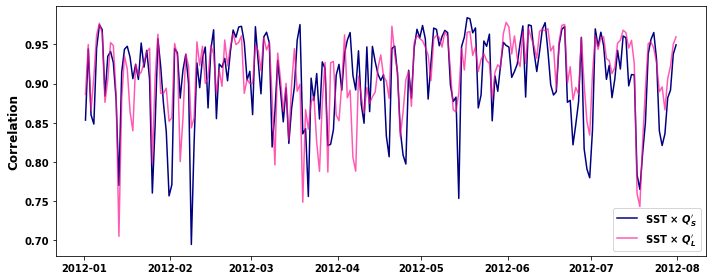

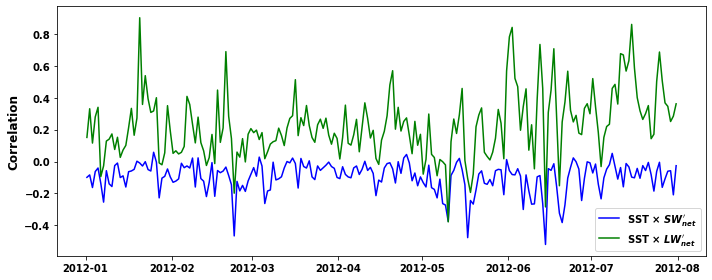

In [418]:
timer=shf_band.time_counter
plt.figure(figsize=(10,4))
plt.plot(timer,QsR,label=r'SST $\times$ $Q_{S}^{\prime}$',color='navy')
plt.plot(timer,QlR,label=r'SST $\times$ $Q_{L}^{\prime}$',color='deeppink',alpha=0.7)
plt.ylabel('Correlation',fontsize=12,fontweight='bold')
plt.legend(loc=4)
plt.tight_layout()

plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/heatflux_dominance/rtimeseries_Qs_Ql.png')


plt.figure(figsize=(10,4))

plt.plot(timer,QswR,label=r'SST $\times$ $SW_{net}^{\prime}$',color='blue')
plt.plot(timer,QlwR,label=r'SST $\times$ $LW_{net}^{\prime}$',color='green')
plt.ylabel('Correlation',fontsize=12,fontweight='bold')
plt.legend(loc=4)
plt.tight_layout()

plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/heatflux_dominance/rtimeseries_SW_LW.png')

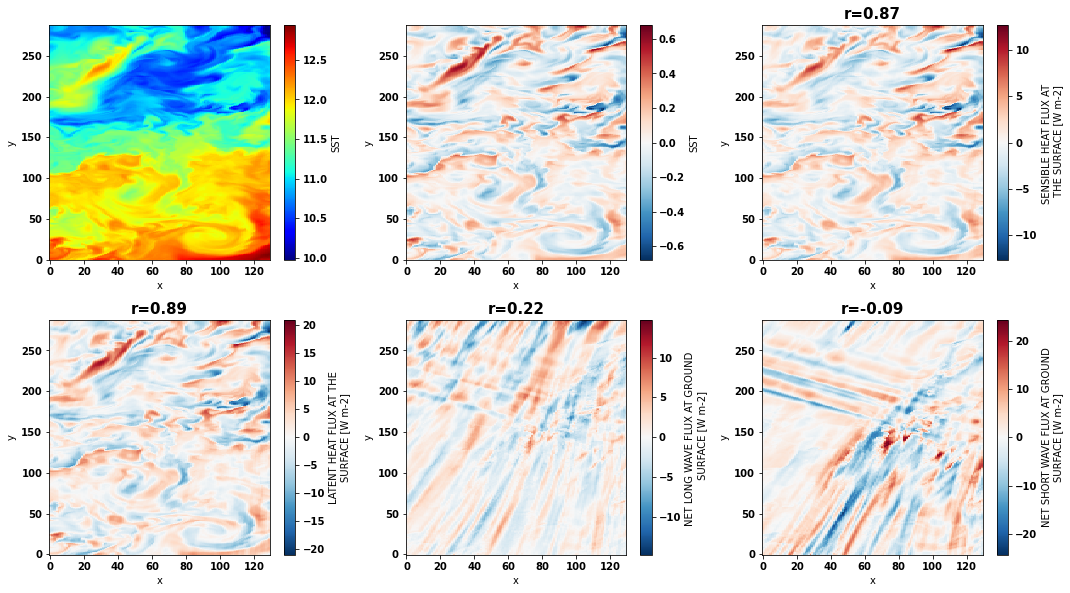

In [13]:
ddy=5

plt.figure(figsize=(15,12))
plt.subplot(3,3,1)
tf[ddy,xlim:-xlim,xlim:-xlim].plot(cmap='jet')
plt.title('')

plt.subplot(3,3,2)
tf_band[ddy].plot()
plt.title('')



plt.subplot(3,3,3)
shf_band[ddy].plot(cbar_kwargs={'label':'SENSIBLE HEAT FLUX AT \n THE SURFACE [W m-2]'})
plt.title('r={0:.2f}'.format(np.corrcoef(var.SST,var.Qs)[0][1]),fontsize=15,fontweight='bold')



plt.subplot(3,3,4)
lhf_band[ddy].plot()
plt.title('r={0:.2f}'.format(np.corrcoef(var.SST,var.Ql)[0][1]),fontsize=15,fontweight='bold')



plt.subplot(3,3,5)
lwhf_band[ddy].plot(cbar_kwargs={'label':'NET LONG WAVE FLUX AT GROUND \n SURFACE [W m-2]'})
plt.title('r={0:.2f}'.format(np.corrcoef(var.SST,var.LWnet)[0][1]),fontsize=15,fontweight='bold')




plt.subplot(3,3,6)
swhf_band[ddy].plot()
plt.title('r={0:.2f}'.format(np.corrcoef(var.SST,var.SWnet)[0][1]),fontsize=15,fontweight='bold')




plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/heatflux_dominance/spatial_example.png')



In [348]:
# SHFLX=varF.shflx[:,1:-1,1:-1].groupby("time_counter.dayofyear").mean()
# SHFLX=SHFLX[:,120:-120,120:800].compute()


In [347]:
# SHFLX_band=tophat_bandpass_2d(SHFLX[:1],lowcut=45,highcut=1)[:,xlim:-xlim,xlim:-xlim]

# Spectral Analysis

In [11]:
#loading SMTH values
lht=vart.LH[:,1:-1,1:-1] #latent heat
lht=lht[:,30:-30,30:200].compute();

sht=vart.HFX[:,1:-1,1:-1] #upward heatflux (sensible)
sht=sht[:,30:-30,30:200].compute();

tt=vart.SST[:,1:-1,1:-1]-273.15 #SST
tt=tt[:,30:-30,30:200].compute();


In [12]:
# chunks_new={'dayofyear':40}
# Tt=varT.temp.groupby("time_counter.dayofyear").mean()
# Tt=Tt.chunk(chunks=chunks_new);
# Tt=Tt[:,120:-120,120:800].compute();

In [22]:
with ProgressBar():
    Tf=xrft.isotropic_power_spectrum(tf.drop(['nav_lat', 'nav_lon']),
                                     dim=['x','y'],nfactor=1,truncate='True',detrend='linear', window=True).real
    Tt=xrft.isotropic_power_spectrum(tt.drop(['nav_lat', 'nav_lon']),
                                     dim=['x','y'],nfactor=1,truncate='True',detrend='linear', window=True).real
    TQsf=xrft.isotropic_cross_spectrum(tf.drop(['nav_lat', 'nav_lon']),shf.drop(['nav_lat', 'nav_lon']),
                                     dim=['x','y'],nfactor=1,truncate='True',detrend='linear', window=True).real
    TQst=xrft.isotropic_cross_spectrum(tt.drop(['nav_lat', 'nav_lon']),sht.drop(['nav_lat', 'nav_lon']),
                                     dim=['x','y'],nfactor=1,truncate='True',detrend='linear', window=True).real
    TQlf=xrft.isotropic_cross_spectrum(tf.drop(['nav_lat', 'nav_lon']),lhf.drop(['nav_lat', 'nav_lon']),
                                     dim=['x','y'],nfactor=1,truncate='True',detrend='linear', window=True).real
    TQlt=xrft.isotropic_cross_spectrum(tt.drop(['nav_lat', 'nav_lon']),lht.drop(['nav_lat', 'nav_lon']),
                                     dim=['x','y'],nfactor=1,truncate='True',detrend='linear', window=True).real

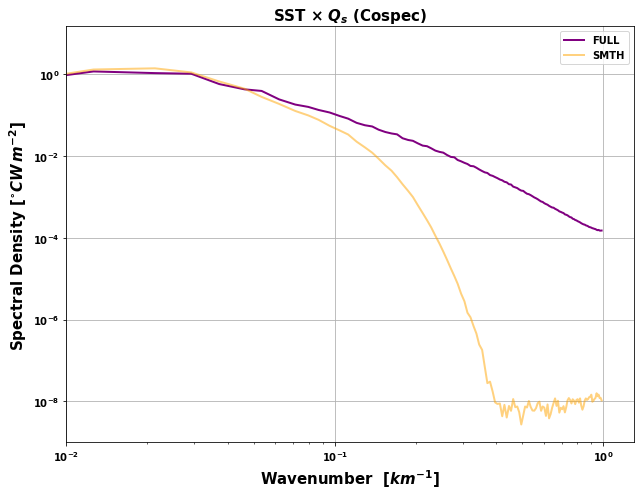

In [54]:
plt.figure(figsize=(9,7))


plt.plot((TQsf.freq_r/dxx),(np.nanmean(TQsf,axis=0)),label='FULL',linewidth=2,color='purple')
plt.plot((TQst.freq_r/dxx),(np.nanmean(TQst,axis=0)),alpha=0.5,label='SMTH',linewidth=2,color='orange')
# plt.plot([1/50,1/50],[1000,0],'k--')


plt.legend()



plt.xlabel(r'Wavenumber  $[km^{-1}]$',fontweight='bold',fontsize=15)
plt.ylabel(r'Spectral Density [$^{\circ}C W\,m^{-2}$] ',fontweight='bold',fontsize=15)
plt.title(r'SST $\times$ $Q_s$ (Cospec)',fontweight='bold',fontsize=15)
# plt.yscale('symlog',linthresh=1e-5)
plt.yscale('log')


plt.xscale('log')

plt.ylim(-1e-3,15)
plt.xlim(1e-2,0)
plt.grid()

plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/1_WRF/spec_avg_SST_SensibleHFX.png')




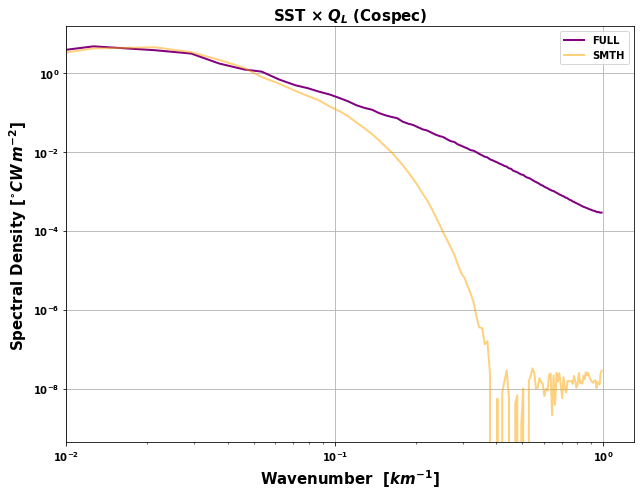

In [55]:
plt.figure(figsize=(9,7))


plt.plot((TQlf.freq_r/dxx),(np.nanmean(TQlf,axis=0)),label='FULL',linewidth=2,color='purple')
plt.plot((TQlt.freq_r/dxx),(np.nanmean(TQlt,axis=0)),alpha=0.5,label='SMTH',linewidth=2,color='orange')
# plt.plot([1/50,1/50],[1000,0],'k--')


plt.legend()



plt.xlabel(r'Wavenumber  $[km^{-1}]$',fontweight='bold',fontsize=15)
plt.ylabel(r'Spectral Density [$^{\circ}C W\,m^{-2}$] ',fontweight='bold',fontsize=15)
plt.title(r'SST $\times$ $Q_L$ (Cospec)',fontweight='bold',fontsize=15)
# plt.yscale('symlog',linthresh=1e-5)
plt.yscale('log')


plt.xscale('log')

plt.ylim(-1e-3,15)
plt.xlim(1e-2,0)
plt.grid()

plt.tight_layout()






plt.savefig('/homes/metogra/iufarias/Documents/figures/1_WRF/spec_avg_SST_LatentHFX.png')



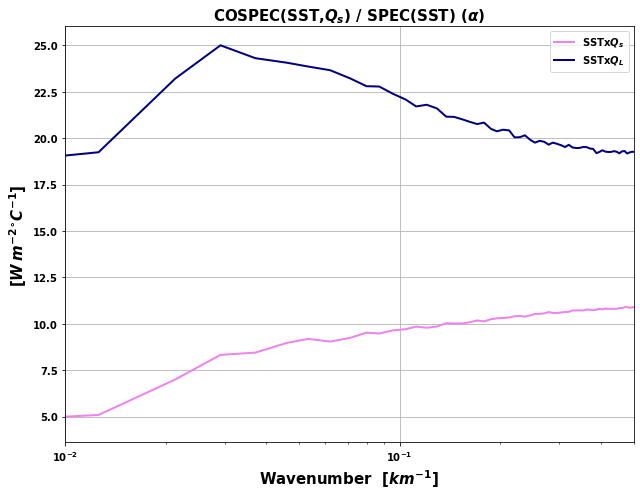

In [56]:

plt.figure(figsize=(9,7))


plt.plot((TQsf.freq_r/dxx),(np.nanmean(TQsf/Tf,axis=0)),label='SSTx$Q_s$',linewidth=2,color='violet')
plt.plot((TQlf.freq_r/dxx),(np.nanmean(TQlf/Tf,axis=0)),label='SSTx$Q_L$',linewidth=2,color='navy')

# plt.plot((TQlt.freq_r/dxx),(np.nanmean(TQlt/Tt,axis=0)),label='SMTH',linewidth=2,color='gold')
# plt.plot((TQst.freq_r/dxx),(np.nanmean(TQst/Tt,axis=0)),label='SMTH',linewidth=2,color='gold')
# plt.plot([1/50,1/50],[1000,0],'k--')


plt.legend()

plt.xlabel(r'Wavenumber  $[km^{-1}]$',fontweight='bold',fontsize=15)
plt.ylabel(r'[$W\,m^{-2}$$^{\circ}$$C^{-1}$] ',fontweight='bold',fontsize=15)
plt.title(r'COSPEC(SST,$Q_s$) / SPEC(SST) ($\alpha$)',fontweight='bold',fontsize=15)

# plt.yscale('symlog',linthresh=1e-5)
# plt.yscale('log')


plt.xscale('log')

# plt.ylim(-1e-3,15)
plt.xlim(1e-2,0.5)
plt.grid()

plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/1_WRF/spec_alpha_Qs_Ql.png')






# Differences between components

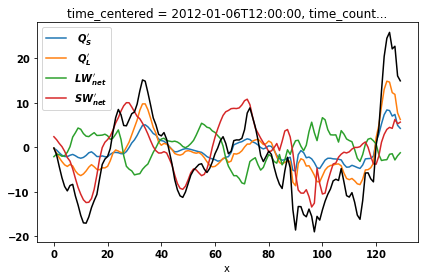

In [410]:
shflx_band= swhf_band - shf_band - lhf_band - lwhf_band


plt.figure()

(-shf_band)[ddy,195,:].plot(label=r' $Q_{S}^{\prime}$')
(-lhf_band)[ddy,195,:].plot(label=r' $Q_{L}^{\prime}$')
(-lwhf_band)[ddy,195,:].plot(label=r'$LW_{net}^{\prime}$')
(swhf_band)[ddy,195,:].plot(label=r'$SW_{net}^{\prime}$')

shflx_band[ddy,195,:].plot(color='k')


plt.legend()

plt.tight_layout()

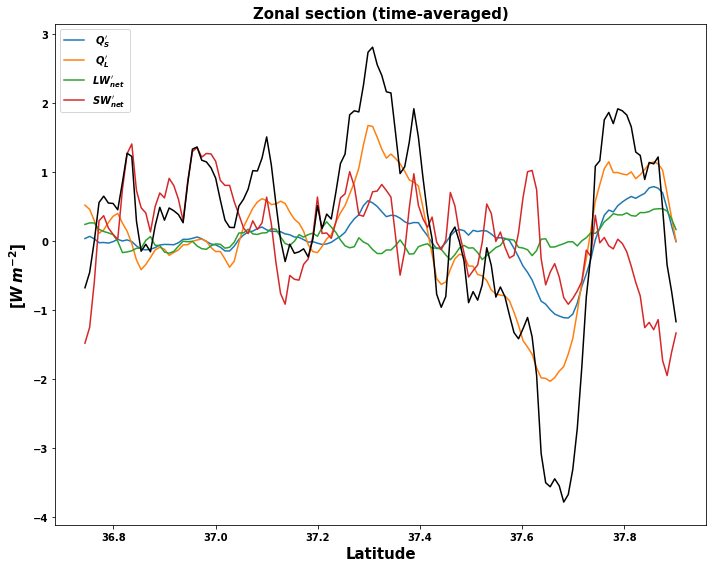

In [414]:
plt.figure(figsize=(10,8))

# np.abs(shf_band)[ddy,195,:].plot(label=r' $Q_{S}^{\prime}$')
# np.abs(lhf_band)[ddy,195,:].plot(label=r' $Q_{L}^{\prime}$')

(-shf_band)[:,195,:].mean(axis=0).plot(x='nav_lat',label=r' $Q_{S}^{\prime}$')
(-lhf_band)[:,195,:].mean(axis=0).plot(x='nav_lat',label=r' $Q_{L}^{\prime}$')
plt.legend()
plt.title('')


# plt.figure()
# np.abs(lwhf_band)[ddy,195,:].plot(label=r'$LW_{net}^{\prime}$')
# np.abs(swhf_band)[ddy,195,:].plot(label=r'$SW_{net}^{\prime}$')

(-lwhf_band)[:,195,:].mean(axis=0).plot(x='nav_lat',label=r'$LW_{net}^{\prime}$')
(swhf_band)[:,195,:].mean(axis=0).plot(x='nav_lat',label=r'$SW_{net}^{\prime}$')
(shflx_band)[:,195,:].mean(axis=0).plot(x='nav_lat',color='k')


plt.title('Zonal section (time-averaged)',fontsize=15,fontweight='bold')
plt.ylabel(r'[$W\,m^{-2}$]',fontsize=15,fontweight='bold')
plt.xlabel(r'Latitude',fontsize=15,fontweight='bold')

plt.legend(loc=2)

plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/heatflux_dominance/zonalsec_balance_prime.png')



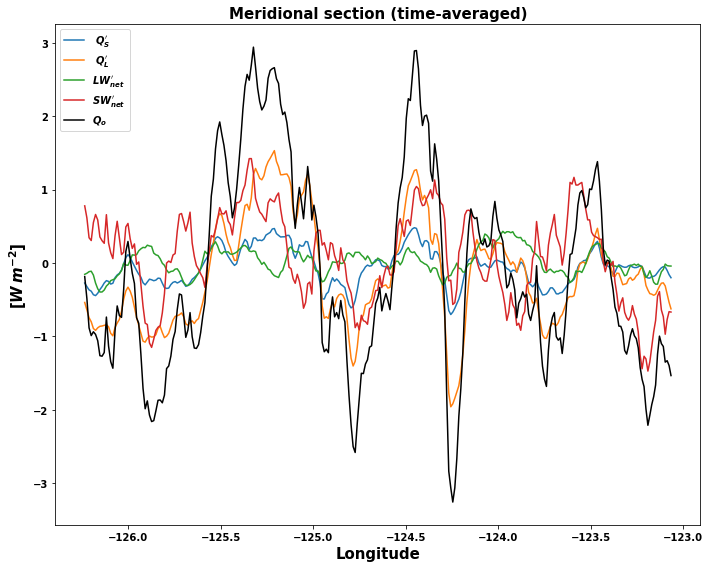

In [415]:
plt.figure(figsize=(10,8))

# np.abs(shf_band)[ddy,195,:].plot(label=r' $Q_{S}^{\prime}$')
# np.abs(lhf_band)[ddy,195,:].plot(label=r' $Q_{L}^{\prime}$')

(-shf_band)[:,:,65].mean(axis=0).plot(x='nav_lon',label=r' $Q_{S}^{\prime}$')
(-lhf_band)[:,:,65].mean(axis=0).plot(x='nav_lon',label=r' $Q_{L}^{\prime}$')

# plt.figure()
# np.abs(lwhf_band)[ddy,195,:].plot(label=r'$LW_{net}^{\prime}$')
# np.abs(swhf_band)[ddy,195,:].plot(label=r'$SW_{net}^{\prime}$')

(-lwhf_band)[:,:,65].mean(axis=0).plot(x='nav_lon',label=r'$LW_{net}^{\prime}$')
(swhf_band)[:,:,65].mean(axis=0).plot(x='nav_lon',label=r'$SW_{net}^{\prime}$')
(shflx_band)[:,:,65].mean(axis=0).plot(x='nav_lon',color='k',label=r'$Q_o$')



plt.title('Meridional section (time-averaged)',fontsize=15,fontweight='bold')
plt.ylabel(r'[$W\,m^{-2}$]',fontsize=15,fontweight='bold')
plt.xlabel(r'Longitude',fontsize=15,fontweight='bold')

plt.legend(loc=2)

plt.tight_layout()


plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/heatflux_dominance/meridionalsec_balance_prime.png')



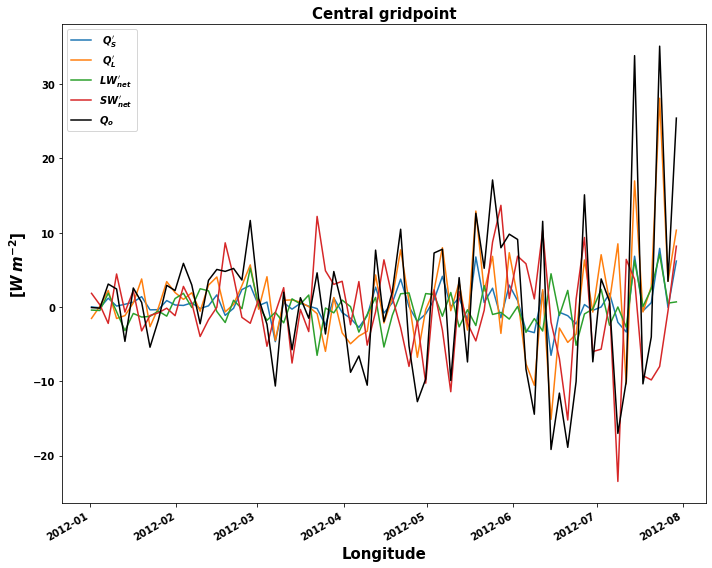

In [406]:
plt.figure(figsize=(10,8))

dec=3
(-shf_band)[::dec,195,65].plot(x='time_counter',label=r' $Q_{S}^{\prime}$')
(-lhf_band)[::dec,195,65].plot(x='time_counter',label=r' $Q_{L}^{\prime}$')


(-lwhf_band)[::dec,195,65].plot(x='time_counter',label=r'$LW_{net}^{\prime}$')
(swhf_band)[::dec,195,65].plot(x='time_counter',label=r'$SW_{net}^{\prime}$')
(shflx_band)[::dec,195,65].plot(x='time_counter',color='k',label=r'$Q_o$')



plt.title('Central gridpoint',fontsize=15,fontweight='bold')
plt.ylabel(r'[$W\,m^{-2}$]',fontsize=15,fontweight='bold')
plt.xlabel(r'Longitude',fontsize=15,fontweight='bold')


plt.legend(loc=2)

plt.tight_layout()

# Scaling Heatflux components

In [34]:
import pandas as pd
timer=pd.DatetimeIndex(varf.time_counter.groupby("time_counter.dayofyear").mean())

In [98]:
ratio=(shf_band)/(lhf_band)

In [99]:
ratio.mean(axis=1).mean(axis=1).mean(axis=0)

<xarray.DataArray ()>
array(0.47828782, dtype=float32)

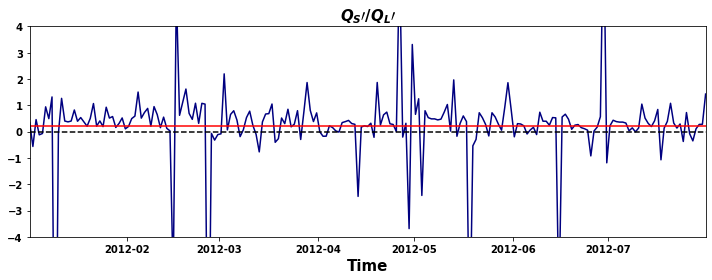

In [107]:
rval=ratio[:,144,65]

plt.figure(figsize=(10,4))
plt.plot(timer,rval,color='navy')
plt.plot(timer,np.zeros(rval.shape),linestyle='--',color='k')
plt.plot(timer,np.zeros(rval.shape) + rval.mean().data,color='red')
plt.title(r'${Q_{S}\prime}$/${Q_{L}\prime}$',fontsize=15,fontweight='bold')
plt.ylim(-4,4)
plt.xlim(timer[0],timer[-1])
plt.xlabel('Time',fontsize=15,fontweight='bold')
plt.tight_layout()


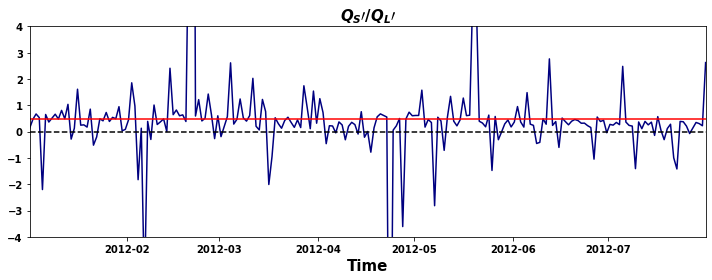

In [109]:
rval=ratio[:].mean(axis=1).mean(axis=1)

plt.figure(figsize=(10,4))
plt.plot(timer,rval,color='navy')
plt.plot(timer,np.zeros(rval.shape),linestyle='--',color='k')
plt.plot(timer,np.zeros(rval.shape) + rval.mean().data,color='red')
plt.title(r'${Q_{S}\prime}$/${Q_{L}\prime}$',fontsize=15,fontweight='bold')
plt.ylim(-4,4)
plt.xlim(timer[0],timer[-1])
plt.xlabel('Time',fontsize=15,fontweight='bold')
plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/heatflux_dominance/scaling_horizontalMean.png')



findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


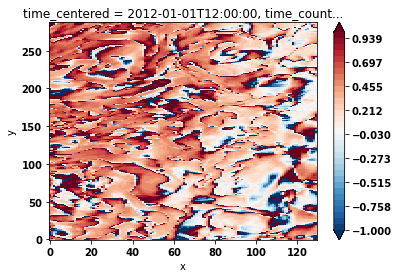

In [80]:
plt.figure()
(ratio)[0].plot(levels=np.linspace(-1,1,34))

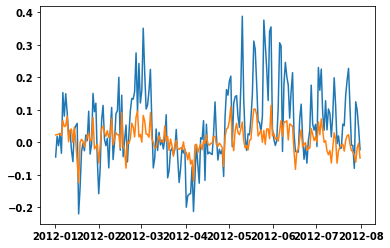

In [110]:
plt.figure()
plt.plot(timer,lhf_band.mean(axis=1).mean(axis=1))
plt.plot(timer,shf_band.mean(axis=1).mean(axis=1))



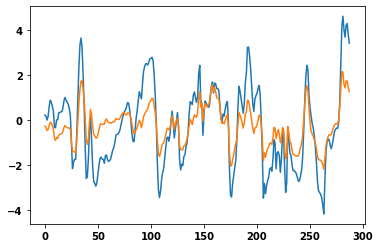

In [112]:
plt.figure()
plt.plot(lhf_band[0,:,65])
plt.plot(shf_band[0,:,65])



In [113]:
lhf_band

<xarray.DataArray 'LH' (time_counter: 213, y: 288, x: 130)>
array([[[  1.5778207 ,   2.2309992 ,   0.46200284, ...,  -0.91397786,
          -0.08361406,   1.0734135 ],
        [  0.12435663,  -0.02140691,  -1.8997109 , ...,  -0.8932173 ,
          -0.37017584,   0.4782959 ],
        [ -1.4029393 ,  -2.062301  ,  -3.5216055 , ...,  -0.75012004,
          -0.5039205 ,  -0.05900847],
        ...,
        [  0.07321654,   0.05903379,  -0.07837223, ...,  -0.30532444,
           0.17416728,   0.9950895 ],
        [  0.3174576 ,   0.18949352,  -0.07507049, ...,  -0.8270685 ,
          -0.45269096,   0.9034325 ],
        [  1.292184  ,   0.8065048 ,   0.12835528, ...,  -1.3502426 ,
          -0.8823866 ,   0.6472931 ]],

       [[  1.0889084 ,  -0.44931716,   0.179516  , ...,   0.64524096,
           1.0003806 ,   1.3601497 ],
        [  0.7721798 ,   0.0786059 ,   0.27412093, ...,   0.907649  ,
           1.2398604 ,   1.553502  ],
        [ -0.05088599,   0.4800415 ,   0.64007205, ...,   1.2309088 ,
           1.5260434 ,   1.8305968 ],
...
        [  3.6708136 ,   3.5972466 ,   2.7628264 , ..., -18.034632  ,
         -19.41172   , -16.472576  ],
        [  2.9203353 ,   3.0986512 ,   3.0768    , ...,  -9.427809  ,
         -13.734688  , -15.588143  ],
        [  2.1694336 ,   2.3747423 ,   2.9012265 , ...,  -3.1038842 ,
          -5.087124  ,  -8.56136   ]],

       [[  2.400665  ,   1.8930721 ,   1.8753014 , ...,  -2.0693662 ,
           0.13643007,   1.4101595 ],
        [  0.37222436,   0.04327287,  -0.40429002, ...,  -3.176796  ,
          -1.6426183 ,  -0.28044125],
        [ -0.38516825,  -1.0343304 ,  -1.6785953 , ...,  -2.097772  ,
          -3.0861366 ,  -2.5199347 ],
        ...,
        [ -2.798168  ,  -3.2606986 ,  -3.1333406 , ...,   4.5025125 ,
           4.324838  ,   3.8658204 ],
        [ -2.382085  ,  -3.2010956 ,  -3.2990317 , ...,   4.433219  ,
           4.548315  ,   4.534712  ],
        [ -1.2238202 ,  -2.9111588 ,  -3.628443  , ...,   3.9483716 ,
           4.315787  ,   4.2325263 ]]], dtype=float32)
Coordinates:
    nav_lat        (y, x) float32 33.69 33.7 33.71 33.72 ... 39.34 39.34 39.35
    nav_lon        (y, x) float32 -124.3 -124.3 -124.3 ... -125.0 -125.0 -124.9
    time_centered  (time_counter) datetime64[ns] 2012-01-01T12:00:00 ... 2012...
  * time_counter   (time_counter) datetime64[ns] 2012-01-01T12:00:00 ... 2012...
Dimensions without coordinates: y, x
Attributes:
    long_name:           LATENT HEAT FLUX AT THE SURFACE
    units:               W m-2
    online_operation:    average
    interval_operation:  12 s
    interval_write:      1 d
    cell_methods:        time: mean (interval: 12 s)

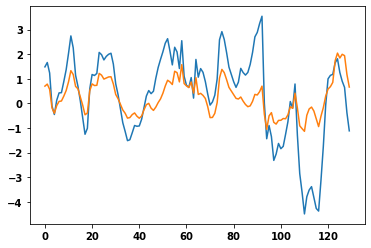

In [114]:
plt.figure()
plt.plot(lhf_band[0,144,:])
plt.plot(shf_band[0,144,:])

